In [1]:
import subprocess
import os
import shutil
import logging
import re
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from itertools import permutations

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

CATEGORIES = [
    "1_WALL",
    "2_FLOOR",
    "3_ROOF",
    "4_CEILING",
    "5_FOOTPATH",
    "6_GRASS",
    "7_COLUMN",
    "8_DOOR",
    "9_WINDOW",
    "10_STAIR",
    "11_RAILING",
    "12_RWP",
    "13_OTHER",
]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Class for data preprocessing

There are a few linked stages for preprocessing the data, so some kind of class to store things and avoid configs being passed everywhere probably makes sense.

It needs to be capable of taking care of the following tasks:
- reading the raw .bin files from Aleks and converting them into usable .ply files, as per the mesh_extraction notebook
- performing relevant transforms on these meshes (scaling, axis fixing, probably recentering too for train/test/val splitting)
- taking transformed meshes and performing visualisations to help with test/train/val splitting
- taking the finished meshes for the different splits and generating pointclouds from them at a requested resolution
- converting the data into .pth files for use in Pointcept

Let's do some explorations to see if that is possible.

In [8]:
class ParametrixPreprocessor():

    def __init__(
        self, label="park_row", cc_path="org.cloudcompare.CloudCompare",
        root_dir="/home/sogilvy/repos/Pointcept/data/parametrix"
    ):
            
        self.label = label
        self.cc_path = cc_path
        
        # Required directories
        self.root_dir = Path(root_dir)
        self.mesh_dir = self.root_dir / "meshes"
        self.raw_mesh_dir = self.mesh_dir / "raw"
        self.extraction_dir = self.mesh_dir / "extracted" / label
        self.processed_mesh_dir = self.mesh_dir / "processed" / label

        # File paths
        self.raw_mesh_path = self.raw_mesh_dir / f"{label}.bin"
        self.raw_mesh_path_temp = self.extraction_dir / f"{label}.bin"

        # A dict to hold loaded and derived per-category information.
        # This can be non-exhaustive based on present categories!
        self.category_dict = {}

    @property
    def meshes(self):
        if not self.category_dict: return {}
        return {category: data['mesh'] for category, data in self.category_dict.items()}

    @property
    def total_mesh_surface_area(self):
        return sum(data['surface_area'] for data in self.category_dict.values()) 

    @property
    def surface_areas(self):
        return {category: data['surface_area'] for category, data in self.category_dict.items()}
    
    def prepare_mesh_extraction(self):
        """
        Prepare necessary dirs and copy raw .bin mesh file over to get
        around CC limitations.
        """
        if self.extraction_dir.exists():
            logger.info("Cleaning .bin extraction dirs.")
            shutil.rmtree(self.extraction_dir.as_posix())
        else:
            logger.info("Creating .bin extraction dirs.")
        self.extraction_dir.mkdir(parents=True, exist_ok=True)
        # Copy raw mesh file over.
        shutil.copy(self.raw_mesh_path.as_posix(), self.raw_mesh_path_temp.as_posix())       

    def split_bin_by_category(self):
        logger.info(f"Splitting bin file {self.raw_mesh_path_temp} by category...")
        for category in CATEGORIES:
            command_regex = [
                self.cc_path,
                "-SILENT",
                "-O", self.raw_mesh_path_temp.name,
                "-SELECT_ENTITIES",
                "-REGEX", category,
                "-RENAME_ENTITIES", category.lower(),
                "-NO_TIMESTAMP", "-SAVE_MESHES"
            ]
    
            logger.info(f"  extracting category: {category}")
            try:
                result = subprocess.run(command_regex, cwd=self.extraction_dir, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                # print("CloudCompare output:", result.stdout.decode())
                # print("CloudCompare errors:", result.stderr.decode())
            except subprocess.CalledProcessError as e:
                print(f"CloudCompare failed with error: {e.stderr.decode()}")
    
    def extract_meshes_from_bin(self):
        """
        Extract .ply files from the raw .bin files.
        """
        self.prepare_mesh_extraction()
        self.split_bin_by_category()
    
        # Cloudcompare appends an index suffix to renamed files when multiple entities are loaded
        # So we'll strip this suffix for deterministic file names going forward.
        # Regular expression to match filenames ending with '_<integer>.bin'        
        pattern = re.compile(r"^(.*?_\d+)\.(bin)$")
       
        for file_path in self.extraction_dir.iterdir():
            if file_path.is_file() and pattern.match(file_path.name):
                new_file_stem = re.sub(r'_\d+$', '', file_path.stem)
                new_file_path = file_path.with_name(f"{new_file_stem}{file_path.suffix}")
                file_path.rename(new_file_path)

                # Now convert the file to a .ply file for use outside of CloudCompare.
                command_convert = [
                    self.cc_path,
                    "-SILENT",
                    "-O", new_file_path.name,
                    "-M_EXPORT_FMT", "PLY",
                    "-NO_TIMESTAMP", "-SAVE_MESHES",
                ]
                try:
                    # Run the command as a subprocess
                    logger.info(f"  converting {new_file_path.name}")
                    result = subprocess.run(command_convert, cwd=self.extraction_dir, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                except subprocess.CalledProcessError as e:
                    print(f"CloudCompare failed with error: {e.stderr.decode()}")

                # Finally unlink the intermediary .bin file
                new_file_path.unlink()

        # Unlink the original .bin file duplicate
        self.raw_mesh_path_temp.unlink()
        
        # Summarise created files
        logger.info("Converted .bin files to .ply files.")
        # for file in self.extraction_dir.iterdir():
        #     logger.info(f"  {file.name}")

    def transform_meshes(self):
        """
        Takes the extracted .ply meshes, swaps z-y axes while maintaining chirality, rescales from cm to m,
        and recenters all meshes so that the center of their combined AABB is at (0, 0, 0).
        """
        # List of input .ply files with relative paths
        ply_files = [f for f in self.extraction_dir.iterdir() if f.suffix == '.ply']
        logger.info("Transforming meshes...")
    
        # Transformation matrix to switch Y and Z axes, reverse X axis, and scale by 0.01
        transform_matrix = np.array([
            [-0.01,  0,     0,    0],  # Reverse X axis and scale by 0.01
            [0,      0,  0.01,    0],  # Y becomes Z and scale by 0.01
            [0,   0.01,     0,    0],  # Z becomes Y and scale by 0.01
            [0,      0,     0,    1]   # Homogeneous coordinate
        ])
    
        # Initialize variables to compute the combined AABB
        global_min_bound = np.array([np.inf, np.inf, np.inf])
        global_max_bound = np.array([-np.inf, -np.inf, -np.inf])
    
        # Step 1: Compute the combined AABB over all meshes
        meshes = []  # Store meshes for later processing
        for ply_file in ply_files:
            mesh = o3d.io.read_triangle_mesh(ply_file.as_posix())
            mesh.compute_vertex_normals()
            mesh.transform(transform_matrix)  # Apply initial transformation
            
            # Update global AABB
            min_bound = np.asarray(mesh.get_min_bound())
            max_bound = np.asarray(mesh.get_max_bound())
            global_min_bound = np.minimum(global_min_bound, min_bound)
            global_max_bound = np.maximum(global_max_bound, max_bound)
            
            meshes.append((mesh, ply_file))  # Store the mesh and its corresponding file for later processing
    
        # Step 2: Calculate the center of the global AABB
        aabb_center = (global_min_bound + global_max_bound) / 2
    
        # Step 3: Recenter each mesh so that the AABB center is at (0, 0, 0)
        for mesh, ply_file in meshes:
            # Translate mesh to center of global AABB
            mesh.translate(-aabb_center)
            # Overwrite the .ply file with the transformed mesh
            o3d.io.write_triangle_mesh(ply_file.as_posix(), mesh)
        
        logger.info("Mesh transformation complete!")
    
    def create_meshes(self):
        """
        Run the full mesh extraction and transformation pipeline.
        """
        self.extract_meshes_from_bin()
        self.transform_meshes()

    def load_processed_meshes(self):
        """
        Loads the processed meshes and stores the file paths and loaded meshes in the category dict.
        """
        ply_files = [f for f in self.extraction_dir.iterdir() if f.suffix == '.ply']
        for file_path in ply_files:           
            file_stem = file_path.stem.upper()
            for category in CATEGORIES:
                if category in file_stem:  # Match based on the category prefix
                    self.category_dict[category] = {}
                    self.category_dict[category]["file"] = file_path
                    mesh = o3d.io.read_triangle_mesh(file_path.as_posix())
                    self.category_dict[category]["mesh"] = mesh
                    self.category_dict[category]["surface_area"] = mesh.get_surface_area()
                    break                  

    def get_aabb_all_meshes(self):
        """
        Returns the min and max AABB bounds across all meshes in the form of a dict.
        """
        global_min_bound = np.array([np.inf, np.inf, np.inf])  # Initialize to positive infinity
        global_max_bound = np.array([-np.inf, -np.inf, -np.inf])  # Initialize to negative infinity

        # Compute the combined AABB over all meshes
        for category, mesh in self.meshes.items():
            if mesh is not None and not mesh.is_empty():
                # Get the min and max bounds of the current mesh
                min_bound = np.asarray(mesh.get_min_bound())
                max_bound = np.asarray(mesh.get_max_bound())
                
                # Update the global AABB bounds
                global_min_bound = np.minimum(global_min_bound, min_bound)
                global_max_bound = np.maximum(global_max_bound, max_bound)

        # Return the combined AABB
        return {
            "min": global_min_bound,
            "max": global_max_bound
        }

    def get_least_populous_categories(self, n):
        """
        Returns a list of the n least populous mesh categories based on surface area.

        Args:
            n (int): The number of least populous categories to return.

        Returns:
            list: A list of the n least populous category names.
        """
        # Access surface areas from the class instance
        surface_areas = self.surface_areas
        
        # Sort categories by surface area in ascending order and get the first n categories
        sorted_categories = sorted(surface_areas, key=surface_areas.get)
        return sorted_categories[:n]
    
    def generate_toy_pcds(self, total_points=5000, normalize_by_area=True, categories=None):
        """
        Generate point clouds from the meshes stored in category_dict.
        
        Args:
            total_points (int): The total number of points to generate.
            normalize_by_area (bool): If True, normalize the number of points generated per category based on surface area.
            categories (list, optional): List of categories to generate point clouds for. Defaults to None (all categories).
        
        Returns:
            dict: A dictionary with categories as keys and sampled point clouds as values.
        """
        # Set categories to all keys in category_dict if not provided
        all_cats = False
        total = self.total_mesh_surface_area
        if categories is None:
            all_cats = True
            categories = list(self.category_dict.keys())
        else:
            total = sum(data['surface_area'] for cat, data in self.category_dict.items() if cat in categories)
            
        logger.info(f"Generating toy pointclouds for categories {categories}.")
        logger.info(f"Sampling {total_points} total points. Normalize_by_area = {normalize_by_area}")       
        pcd_dict = {}
        
        # Iterate over the specified categories
        for category in categories:
            if category in self.category_dict:
                data = self.category_dict[category]
                mesh = data['mesh']
                surface_area = data['surface_area']
                
                # Check if mesh is valid
                if mesh is not None and not mesh.is_empty():
                    # Compute the number of points to sample
                    if normalize_by_area:
                        # Normalizing by surface area
                        points_to_sample = int((surface_area / total) * total_points)
                    else:
                        # Evenly distribute points across all categories
                        points_to_sample = total_points // len(categories)  # Use the length of the selected categories
                    
                    # Ensure the mesh has vertex normals computed for better sampling
                    mesh.compute_vertex_normals()
    
                    # Sample points from the mesh based on the computed number
                    if points_to_sample > 0:  # Ensure positive number of points
                        sampled_pcd = mesh.sample_points_poisson_disk(number_of_points=points_to_sample)
                        pcd_dict[category] = sampled_pcd
                        logger.info(f"  Sampled {points_to_sample} points for category {category}")
            else:
                logger.warning(f"Category '{category}' not found in category_dict.")
        
        logger.info("Finished generating toy PCDs.")
        self.recent_toy_pcds = pcd_dict
        return pcd_dict


    def generate_cluster_density_arrays(self, n, k_clusters, total_points=5000, normalize_by_area=True):
        """
        Generates cluster density arrays for the n least populous categories using K-means clustering.

        Args:
            n (int): The number of least populous categories to consider.
            k_clusters (int): The number of K-means clusters to generate.
            total_points (int): The total number of points to generate for each category.
            normalize_by_area (bool): If True, normalize the number of points generated per category based on surface area.

        Returns:
            dict: A dictionary mapping each category to its array of cluster centers.
        """
        # Step 1: Get the n least populous categories
        least_populous_categories = self.get_least_populous_categories(n)

        # Step 2: Generate point clouds for the least populous categories
        pcd_dict = self.generate_toy_pcds(total_points=total_points, normalize_by_area=normalize_by_area, categories=least_populous_categories)

        # Step 3: Initialize a dictionary to store cluster means for each category
        category_to_cluster_means = {}

        # Step 4: Perform K-means clustering for each category and store the cluster means
        for category in least_populous_categories:
            if category in pcd_dict:
                # Extract point cloud data from the Open3D PointCloud object
                sampled_pcd = pcd_dict[category]
                sampled_points = np.asarray(sampled_pcd.points)  # Convert to NumPy array

                # Collapse the point clouds to the XY plane
                xy_points = sampled_points[:, :2]

                # Normalize the data
                scaler = StandardScaler()
                xy_points_normalized = scaler.fit_transform(xy_points)  # Normalize the data

                # Perform K-means Clustering
                kmeans = KMeans(n_clusters=k_clusters, random_state=0, init='k-means++')  # Use k-means++ for better initialization
                kmeans.fit(xy_points_normalized)

                # Transform cluster centers back to original scale
                cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

                # Store cluster means in the dictionary
                category_to_cluster_means[category] = cluster_centers

        # Step 5: Return the dictionary with cluster density arrays
        return category_to_cluster_means

    def plot_cluster_means(self, category_to_cluster_means):
        # Step 1: Define colors for each category
        categories = list(category_to_cluster_means.keys())
        colors = plt.colormaps['tab10']  # Updated syntax to use colormap
        
        # Step 2: Get the AABB (Axis-Aligned Bounding Box) across all meshes
        aabb = self.get_aabb_all_meshes()
        min_x, max_x = aabb['min'][0], aabb['max'][0]
        min_y, max_y = aabb['min'][1], aabb['max'][1]
        
        # Calculate the range for preserving aspect ratio
        range_x = max_x - min_x
        range_y = max_y - min_y
        
        # Step 3: Plot all cluster means, color-coded by category
        plt.figure(figsize=(2, 2 * (range_y / range_x)))  # Preserve the aspect ratio of the AABB
        
        for idx, category in enumerate(categories):
            cluster_means = category_to_cluster_means[category]
            
            # Plot cluster means for the current category
            plt.scatter(cluster_means[:, 0], cluster_means[:, 1], 
                        color=colors(idx), label=category, s=100, alpha=0.7, edgecolor='k', marker='o')
        
        # Step 4: Add legend to differentiate categories
        plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1.0), title='Categories')  # Push legend even further outside
        
        # Step 5: Set plot labels and title
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title('Cluster Means for Each Category')
        
        # Step 6: Set the axis limits based on the global AABB to preserve aspect ratio
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)
        
        # Show grid for better visibility
        plt.grid(True)
        
        # Display the plot
        plt.show()




In [9]:
p = ParametrixPreprocessor()
p.load_processed_meshes()

18:40:34 - INFO - Generating toy pointclouds for categories ['12_RWP', '11_RAILING', '13_OTHER', '6_GRASS', '8_DOOR', '10_STAIR', '9_WINDOW', '7_COLUMN'].
18:40:34 - INFO - Sampling 5000 total points. Normalize_by_area = False
18:40:34 - INFO -   Sampled 625 points for category 12_RWP
18:40:34 - INFO -   Sampled 625 points for category 11_RAILING
18:40:35 - INFO -   Sampled 625 points for category 13_OTHER
18:40:35 - INFO -   Sampled 625 points for category 6_GRASS
18:40:35 - INFO -   Sampled 625 points for category 8_DOOR
18:40:36 - INFO -   Sampled 625 points for category 10_STAIR
18:40:36 - INFO -   Sampled 625 points for category 9_WINDOW
18:40:36 - INFO -   Sampled 625 points for category 7_COLUMN
18:40:36 - INFO - Finished generating toy PCDs.


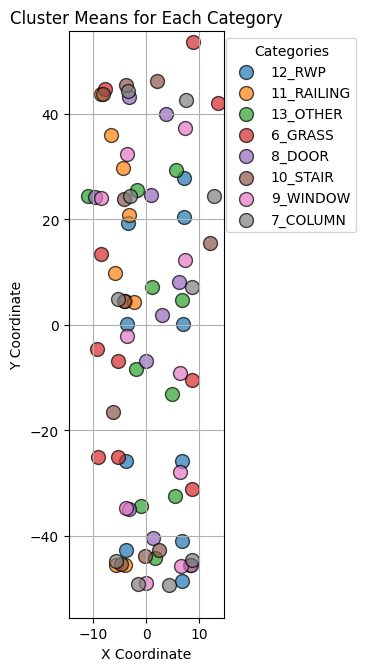

In [13]:
cs = p.generate_cluster_density_arrays(8, 10, normalize_by_area=False)
p.plot_cluster_means(cs)

18:40:45 - INFO - Generating toy pointclouds for categories ['11_RAILING', '12_RWP', '13_OTHER', '7_COLUMN'].
18:40:45 - INFO - Sampling 5000 total points. Normalize_by_area = True
18:40:45 - INFO -   Sampled 601 points for category 11_RAILING
18:40:45 - INFO -   Sampled 139 points for category 12_RWP
18:40:46 - INFO -   Sampled 925 points for category 13_OTHER
18:40:47 - INFO -   Sampled 3334 points for category 7_COLUMN
18:40:47 - INFO - Finished generating toy PCDs.


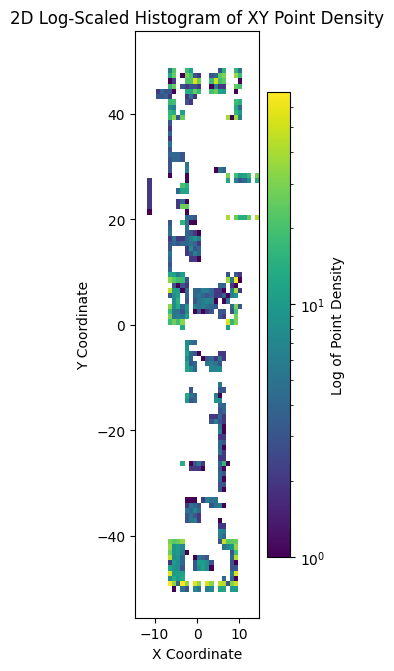

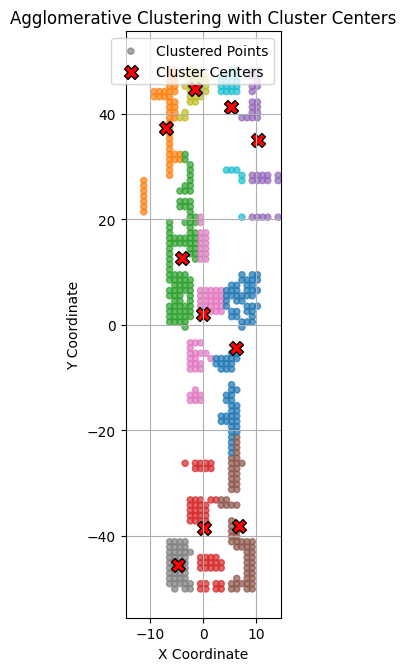

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Step 1: Generate point clouds for the selected categories
selected_categories = ["11_RAILING", "12_RWP", "13_OTHER", "7_COLUMN"]  # Example categories to sample from

# Generate point clouds using the new workflow
pcd_dict = p.generate_toy_pcds(categories=selected_categories)

# Step 2: Extract point clouds and sample points
sampled_point_clouds = []
for category in selected_categories:
    if category in pcd_dict:
        # Extract point cloud data from the Open3D PointCloud object
        sampled_pcd = pcd_dict[category]
        sampled_points = np.asarray(sampled_pcd.points)  # Convert to NumPy array
        sampled_point_clouds.append(sampled_points)

# Step 3: Collapse the point clouds to the XY plane and combine them
xy_points = np.vstack([points[:, :2] for points in sampled_point_clouds])

# Step 4: Compute the AABB (axis-aligned bounding box) across all meshes using get_aabb_all_meshes
aabb_all_meshes = p.get_aabb_all_meshes()  # This will use your provided function

# Extract the min and max bounds for the XY plane from the AABB
min_x, min_y = aabb_all_meshes['min'][:2]  # Use only the first two components (XY)
max_x, max_y = aabb_all_meshes['max'][:2]  # Use only the first two components (XY)

# Calculate the range of the AABB for both axes
range_x = max_x - min_x
range_y = max_y - min_y

# Step 5: Determine the number of bins for each axis to make square cells
desired_bin_width = 1  # Desired bin width (adjust this to control the size of each bin)
num_bins_x = int(np.ceil(range_x / desired_bin_width))
num_bins_y = int(np.ceil(range_y / desired_bin_width))

# Step 6: Generate a 2D log-scaled histogram of point density in the XY plane with scaled plot dimensions
aspect_ratio = range_y / range_x
figsize = (2, 2 * aspect_ratio)  # Scale figure size based on AABB aspect ratio with coefficients 2, 2
plt.figure(figsize=figsize)

hist, xedges, yedges, _ = plt.hist2d(
    xy_points[:, 0], xy_points[:, 1], 
    bins=[num_bins_x, num_bins_y],  # Use calculated number of bins for square cells
    range=[[min_x, max_x], [min_y, max_y]],  # Set histogram boundaries to match the AABB across all meshes
    cmap='viridis',
    norm=LogNorm()  # Apply logarithmic normalization to the color scale
)
plt.colorbar(label='Log of Point Density')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Log-Scaled Histogram of XY Point Density')

# Adjust plot limits to match the AABB
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

plt.show()

# Step 7: Prepare data for Agglomerative Clustering
# Create a grid of x and y coordinates for each bin center
x_centers = (xedges[:-1] + xedges[1:]) / 2  # X bin centers
y_centers = (yedges[:-1] + yedges[1:]) / 2  # Y bin centers
xv, yv = np.meshgrid(x_centers, y_centers)  # Meshgrid for bin centers

# Flatten the grid and the histogram to get the data for clustering
xv_flat = xv.flatten()
yv_flat = yv.flatten()
hist_flat = hist.T.flatten()  # TRANSPOSE to align with meshgrid ordering

# Prepare data where the histogram density is greater than zero
data = np.vstack([xv_flat, yv_flat]).T
data = data[hist_flat > 0]  # Only consider points with density > 0

# Step 8: Normalize the data (optional but often useful for clustering)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)  # Normalize the data

# Step 9: Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=10, linkage='ward')  # Using Ward linkage; adjust as needed
labels = agg_clustering.fit_predict(data_normalized)

# Step 10: Compute Cluster Centers Manually and Transform Back to Original Space
cluster_centers = []
for cluster_label in np.unique(labels):
    # Calculate the mean of all points in each cluster (centroid)
    cluster_points = data_normalized[labels == cluster_label]
    cluster_center = scaler.inverse_transform(cluster_points.mean(axis=0).reshape(1, -1))
    cluster_centers.append(cluster_center)
cluster_centers = np.array(cluster_centers).squeeze()

# Step 11: Visualize the clustering results with cluster centers
plt.figure(figsize=figsize)  # Set fixed figure size with scaling

# Plot the clusters
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7, label='Clustered Points')

# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', s=100, edgecolor='k', label='Cluster Centers')

# Add legend for clusters and centers
plt.legend(loc='upper right')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Agglomerative Clustering with Cluster Centers')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.grid(True)
plt.show()


In [ ]:
# Step 1: Generate point clouds for the selected categories
# selected_categories = ["11_RAILING", "12_RWP", "13_OTHER", "7_COLUMN"]  # Example categories to sample from
selected_categories = ["12_RWP"]

# Generate point clouds using the new workflow
pcd_dict = p.generate_toy_pcds(categories=selected_categories)

# Step 2: Extract point clouds and sample points
sampled_point_clouds = []
for category in selected_categories:
    if category in pcd_dict:
        # Extract point cloud data from the Open3D PointCloud object
        sampled_pcd = pcd_dict[category]
        sampled_points = np.asarray(sampled_pcd.points)  # Convert to NumPy array
        sampled_point_clouds.append(sampled_points)

# Step 3: Collapse the point clouds to the XY plane and combine them
xy_points = np.vstack([points[:, :2] for points in sampled_point_clouds])

# Step 4: Compute the AABB (axis-aligned bounding box) across all meshes using get_aabb_all_meshes
aabb_all_meshes = p.get_aabb_all_meshes()  # This will use your provided function

# Extract the min and max bounds for the XY plane from the AABB
min_x, min_y = aabb_all_meshes['min'][:2]  # Use only the first two components (XY)
max_x, max_y = aabb_all_meshes['max'][:2]  # Use only the first two components (XY)

# Calculate the range of the AABB for both axes
range_x = max_x - min_x
range_y = max_y - min_y

# Step 5: Determine the number of bins for each axis to make square cells
desired_bin_width = 1  # Desired bin width (adjust this to control the size of each bin)
num_bins_x = int(np.ceil(range_x / desired_bin_width))
num_bins_y = int(np.ceil(range_y / desired_bin_width))

# Step 6: Generate a 2D log-scaled histogram of point density in the XY plane with scaled plot dimensions
aspect_ratio = range_y / range_x
figsize = (2, 2 * aspect_ratio)  # Scale figure size based on AABB aspect ratio with coefficients 2, 2
plt.figure(figsize=figsize)

hist, xedges, yedges, _ = plt.hist2d(
    xy_points[:, 0], xy_points[:, 1], 
    bins=[num_bins_x, num_bins_y],  # Use calculated number of bins for square cells
    range=[[min_x, max_x], [min_y, max_y]],  # Set histogram boundaries to match the AABB across all meshes
    cmap='viridis',
    norm=LogNorm()  # Apply logarithmic normalization to the color scale
)
plt.colorbar(label='Log of Point Density')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Log-Scaled Histogram of XY Point Density')

# Adjust plot limits to match the AABB
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

plt.show()

# Step 7: Prepare data for K-means clustering
# Create a grid of x and y coordinates for each bin center
x_centers = (xedges[:-1] + xedges[1:]) / 2  # X bin centers
y_centers = (yedges[:-1] + yedges[1:]) / 2  # Y bin centers
xv, yv = np.meshgrid(x_centers, y_centers)  # Meshgrid for bin centers

# Flatten the grid and the histogram to get the data for clustering
xv_flat = xv.flatten()
yv_flat = yv.flatten()
hist_flat = hist.T.flatten()  # TRANSPOSE to align with meshgrid ordering

# Prepare data where the histogram density is greater than zero
data = np.vstack([xv_flat, yv_flat]).T
data = data[hist_flat > 0]  # Only consider points with density > 0

# Step 8: Normalize the data (optional but often useful for clustering)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)  # Normalize the data

# Step 9: Perform K-means Clustering
kmeans = KMeans(n_clusters=9, random_state=0, init='k-means++')  # Use k-means++ for better initialization
kmeans.fit(data_normalized)
labels = kmeans.labels_
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Transform cluster centers back to original scale

# Step 10: Visualize the clustering results with cluster centers
plt.figure(figsize=figsize)  # Set fixed figure size with scaling

# Plot the clusters
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)

# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', s=100, edgecolor='k')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('K-means Clustering with Cluster Centers')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.grid(True)
plt.show()


In [ ]:
p.surface_areas

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Generate point clouds for each category without normalization
selected_categories = ["11_RAILING", "12_RWP", "13_OTHER", "7_COLUMN"]  # Example categories to sample from

# Generate point clouds using the new workflow without normalization
pcd_dict = p.generate_toy_pcds(categories=selected_categories, normalize_by_area=False)

# Step 2: Initialize a dictionary to store cluster means for each category
category_to_cluster_means = {}

# Step 3: Perform K-means clustering for each category and store the cluster means
for category in selected_categories:
    if category in pcd_dict:
        # Extract point cloud data from the Open3D PointCloud object
        sampled_pcd = pcd_dict[category]
        sampled_points = np.asarray(sampled_pcd.points)  # Convert to NumPy array

        # Collapse the point clouds to the XY plane
        xy_points = sampled_points[:, :2]

        # Normalize the data (optional but often useful for clustering)
        scaler = StandardScaler()
        xy_points_normalized = scaler.fit_transform(xy_points)  # Normalize the data

        # Perform K-means Clustering
        kmeans = KMeans(n_clusters=10, random_state=0, init='k-means++')  # Use k-means++ for better initialization
        kmeans.fit(xy_points_normalized)

        # Transform cluster centers back to original scale
        cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

        # Store cluster means in the dictionary
        category_to_cluster_means[category] = cluster_centers

# Step 4: The result is a dictionary mapping each category to its cluster means
category_to_cluster_means

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assume category_to_cluster_means is already defined
# Example of category_to_cluster_means structure:
# category_to_cluster_means = {
#     "11_RAILING": np.array([[1.2, 3.4], [2.3, 4.5], ...]),
#     "12_RWP": np.array([[0.1, 2.5], [1.8, 3.2], ...]),
#     ...
# }

# Step 1: Define colors for each category
categories = list(category_to_cluster_means.keys())
colors = plt.cm.get_cmap('tab10', len(categories))  # Use a colormap with distinct colors for each category

# Step 2: Plot all cluster means, color-coded by category
plt.figure(figsize=(2, 2 * (range_y / range_x)))  # Preserve the aspect ratio of the AABB

for idx, category in enumerate(categories):
    cluster_means = category_to_cluster_means[category]
    
    # Plot cluster means for the current category
    plt.scatter(cluster_means[:, 0], cluster_means[:, 1], 
                color=colors(idx), label=category, s=100, alpha=0.7, edgecolor='k', marker='o')

# Step 3: Add legend to differentiate categories
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1.0), title='Categories')  # Push legend even further outside

# Step 4: Set plot labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Cluster Means for Each Category')

# Step 5: Set the axis limits based on AABB to preserve aspect ratio
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

# Show grid for better visibility
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
import numpy as np
from itertools import product, permutations
from scipy.spatial.distance import cdist

def find_shortest_random_walk(cluster_means_dict):
    """
    Find the shortest random walk between one cluster from each specific category on the XY plane.

    Args:
        cluster_means_dict (dict): A dictionary where keys are category names and values are arrays of cluster centers.

    Returns:
        tuple: A tuple containing the shortest path (list of cluster centers) and the total distance.
    """
    # Step 1: Extract category names and cluster centers
    categories = list(cluster_means_dict.keys())
    cluster_means = [cluster_means_dict[category] for category in categories]

    # Step 2: Calculate pairwise distances between all clusters in all categories
    num_categories = len(categories)
    distance_matrix = {}
    
    for i in range(num_categories):
        for j in range(i + 1, num_categories):
            category_i = categories[i]
            category_j = categories[j]
            distances = cdist(cluster_means[i], cluster_means[j], metric='euclidean')  # Compute pairwise Euclidean distances
            distance_matrix[(category_i, category_j)] = distances

    # Step 3: Generate all possible combinations of clusters from each category
    cluster_indices = [list(range(len(cluster_means[i]))) for i in range(num_categories)]
    all_combinations = list(product(*cluster_indices))  # Generate combinations of indices

    # Step 4: Find the shortest random walk among all combinations
    min_distance = float('inf')
    shortest_path = []

    # Iterate over all combinations to find the shortest path
    for combination in all_combinations:
        # Generate all possible permutations of visiting each cluster once
        all_permutations = permutations(combination)
        
        for perm in all_permutations:
            current_distance = 0
            path = []
            valid_path = True
            
            for k in range(num_categories - 1):
                from_category = categories[k]
                to_category = categories[k + 1]
                from_index = perm[k]
                to_index = perm[k + 1]

                # Calculate distance from current cluster to the next
                try:
                    current_distance += distance_matrix[(from_category, to_category)][from_index, to_index]
                    path.append(cluster_means_dict[from_category][from_index])
                except KeyError as e:
                    valid_path = False
                    break
            
            # Append the last cluster in the path if valid
            if valid_path:
                path.append(cluster_means_dict[categories[-1]][perm[-1]])

                # Update the shortest path if the current one is shorter
                if current_distance < min_distance:
                    min_distance = current_distance
                    shortest_path = path

    # Return the shortest path and its distance
    return shortest_path, min_distance


shortest_path, min_distance = find_shortest_random_walk(category_to_cluster_means)
print("Shortest Path:", shortest_path)
print("Total Distance:", min_distance)


In [ ]:
cs

In [ ]:
shortest_path

In [ ]:
min_distance

In [ ]:
def plot_shortest_path(shortest_path):
    """
    Plots the shortest path on the XY plane using the full AABB as the axis limits.

    Args:
        shortest_path (list): A list of cluster centers representing the shortest path.
    """
    # Step 1: Get the AABB using the class method
    aabb = p.get_aabb_all_meshes()
    min_x, min_y = aabb['min'][:2]  # Use only the first two components (XY)
    max_x, max_y = aabb['max'][:2]  # Use only the first two components (XY)

    # Step 2: Extract X and Y coordinates from the shortest path
    path_points = np.array(shortest_path)
    x_coords, y_coords = path_points[:, 0], path_points[:, 1]

    # Step 3: Create the plot
    plt.figure(figsize=(2, 2 * (max_y - min_y) / (max_x - min_x)))  # Preserve aspect ratio of AABB

    # Plot the points
    plt.scatter(x_coords, y_coords, color='blue', marker='o', s=100, label='Cluster Centers')

    # Connect the points with lines to visualize the path
    plt.plot(x_coords, y_coords, color='red', linestyle='-', linewidth=2, label='Shortest Path')

    # Step 4: Set the axis limits based on the AABB
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Shortest Path Between Clusters on XY AABB')

    # Add a legend
    plt.legend()

    # Show the grid for better readability
    plt.grid(True)

    # Display the plot
    plt.show()

plot_shortest_path(shortest_path)

In [ ]:
shortest_path

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Voronoi, voronoi_plot_2d

def voronoi_finite_polygons_2d(vor, aabb):
    """
    Reconstruct Voronoi polygons to fill a bounding box.
    Adapted from https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram.

    Args:
        vor: A Voronoi diagram object from SciPy.
        aabb (tuple): Tuple containing min_x, max_x, min_y, max_y.

    Returns:
        List of Voronoi regions clipped to the bounding box.
    """
    min_x, max_x, min_y, max_y = aabb

    # Extend the Voronoi diagram to cover the bounding box
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    radius = max(max_x - min_x, max_y - min_y) * 2

    # Construct a map containing all ridges for a Voronoi diagram
    all_ridges = {}
    for (point_idx, neighbor_idx), ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        if point_idx not in all_ridges:
            all_ridges[point_idx] = []
        if neighbor_idx not in all_ridges:
            all_ridges[neighbor_idx] = []
        all_ridges[point_idx].append((neighbor_idx, ridge_vertices))
        all_ridges[neighbor_idx].append((point_idx, ridge_vertices))

    # Reconstruct infinite Voronoi regions into finite ones
    for point_idx, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        # Reconstruct a non-finite region
        ridges = all_ridges[point_idx]
        new_region = [v for v in vertices if v >= 0]

        for neighbor_idx, ridge_vertices in ridges:
            if ridge_vertices[0] >= 0 and ridge_vertices[1] >= 0:
                continue

            # Compute the midpoint of the ridge
            tangent = vor.points[neighbor_idx] - vor.points[point_idx]
            tangent /= np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])

            midpoint = vor.points[[point_idx, neighbor_idx]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, normal)) * normal
            far_point = midpoint + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # Sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def plot_voronoi_single_region(aabb_min, aabb_max, path_points):
    """
    Plots a Voronoi diagram that splits the AABB into two regions:
    1. One containing all points on the shortest path, covering about 10% of the full AABB.
    2. The other containing the unused space.

    Args:
        aabb_min (tuple): The minimum bounds of the AABB.
        aabb_max (tuple): The maximum bounds of the AABB.
        path_points (list): A list of points on the shortest path.
    """
    # Step 1: Compute the convex hull around the shortest path points
    path_points = np.array(path_points)
    hull = ConvexHull(path_points)

    # Step 2: Compute the centroid of the convex hull points
    hull_centroid = np.mean(path_points[hull.vertices], axis=0)

    # Step 3: Set up two points for the Voronoi diagram:
    # 1. One at the centroid of the convex hull (covering the shortest path points)
    # 2. One far away to cover the rest of the AABB
    vor_points = np.array([
        hull_centroid,
        [aabb_max[0] + (aabb_max[0] - aabb_min[0]), aabb_max[1] + (aabb_max[1] - aabb_min[1])],  # Point far outside AABB
    ])
    vor = Voronoi(vor_points)

    # Step 4: Clip Voronoi regions to the AABB
    min_x, max_x = aabb_min[0], aabb_max[0]
    min_y, max_y = aabb_min[1], aabb_max[1]
    aabb = (min_x, max_x, min_y, max_y)
    regions, vertices = voronoi_finite_polygons_2d(vor, aabb)

    # Step 5: Plot the AABB and Voronoi diagram
    plt.figure(figsize=(4, 4 * (max_y - min_y) / (max_x - min_x)))  # Smaller plot, maintaining aspect ratio
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

    # Plot the Voronoi regions
    colors = ['orange', 'lightblue']
    for i, region in enumerate(regions):
        polygon = vertices[region]
        plt.fill(*zip(*polygon), alpha=0.4, color=colors[i % len(colors)], edgecolor='black')

    # Plot the points of the convex hull for reference
    plt.scatter(path_points[:, 0], path_points[:, 1], color='blue', marker='o', s=30, label='Shortest Path Points')

    # Add labels, title, and legend
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Voronoi Region Containing Shortest Path and Remaining AABB Space')
    plt.legend()

    # Show the grid for better readability
    plt.grid(True)

    # Display the plot
    plt.show()

# Example usage:
# p = ParametrixPreprocessor()  # Assume this class is initialized correctly
aabb = p.get_aabb_all_meshes()
min_x, max_x = aabb['min'][0], aabb['max'][0]
min_y, max_y = aabb['min'][1], aabb['max'][1]


# Plot Voronoi diagram splitting AABB into two regions
plot_voronoi_single_region((min_x, min_y), (max_x, max_y), shortest_path)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Voronoi

def voronoi_finite_polygons_2d(vor, aabb):
    """
    Reconstruct Voronoi polygons to fill a bounding box.
    Adapted from https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram.

    Args:
        vor: A Voronoi diagram object from SciPy.
        aabb (tuple): Tuple containing min_x, max_x, min_y, max_y.

    Returns:
        List of Voronoi regions clipped to the bounding box.
    """
    min_x, max_x, min_y, max_y = aabb

    # Extend the Voronoi diagram to cover the bounding box
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    radius = max(max_x - min_x, max_y - min_y) * 2

    # Construct a map containing all ridges for a Voronoi diagram
    all_ridges = {}
    for (point_idx, neighbor_idx), ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        if point_idx not in all_ridges:
            all_ridges[point_idx] = []
        if neighbor_idx not in all_ridges:
            all_ridges[neighbor_idx] = []
        all_ridges[point_idx].append((neighbor_idx, ridge_vertices))
        all_ridges[neighbor_idx].append((point_idx, ridge_vertices))

    # Reconstruct infinite Voronoi regions into finite ones
    for point_idx, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        # Reconstruct a non-finite region
        ridges = all_ridges[point_idx]
        new_region = [v for v in vertices if v >= 0]

        for neighbor_idx, ridge_vertices in ridges:
            if ridge_vertices[0] >= 0 and ridge_vertices[1] >= 0:
                continue

            # Compute the midpoint of the ridge
            tangent = vor.points[neighbor_idx] - vor.points[point_idx]
            tangent /= np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])

            midpoint = vor.points[[point_idx, neighbor_idx]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, normal)) * normal
            far_point = midpoint + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # Sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def plot_voronoi_single_region(aabb_min, aabb_max, path_points):
    """
    Plots a Voronoi diagram that splits the AABB into two regions:
    1. One containing all points on the shortest path, covering about 10% of the full AABB.
    2. The other containing the unused space.

    Args:
        aabb_min (tuple): The minimum bounds of the AABB.
        aabb_max (tuple): The maximum bounds of the AABB.
        path_points (list): A list of points on the shortest path.
    """
    # Step 1: Compute the convex hull around the shortest path points
    path_points = np.array(path_points)
    hull = ConvexHull(path_points)

    # Step 2: Compute the centroid of the convex hull points
    hull_centroid = np.mean(path_points[hull.vertices], axis=0)

    # Step 3: Generate random points around the centroid to create a valid Voronoi region
    np.random.seed(42)  # For reproducibility
    num_random_points = 3  # Add three additional random points around the centroid
    random_points = hull_centroid + np.random.uniform(-1, 1, size=(num_random_points, 2))

    # Step 4: Set up points for the Voronoi diagram:
    # 1. One at the centroid of the convex hull (covering the shortest path points)
    # 2. Random points around the centroid to ensure a valid Voronoi diagram
    # 3. Additional points far outside to cover the rest of the AABB
    far_points = np.array([
        [aabb_max[0] + (aabb_max[0] - aabb_min[0]), aabb_max[1] + (aabb_max[1] - aabb_min[1])],
        [aabb_min[0] - (aabb_max[0] - aabb_min[0]), aabb_min[1] - (aabb_max[1] - aabb_min[1])]
    ])
    vor_points = np.vstack((random_points, hull_centroid, far_points))
    vor = Voronoi(vor_points)

    # Step 5: Clip Voronoi regions to the AABB
    min_x, max_x = aabb_min[0], aabb_max[0]
    min_y, max_y = aabb_min[1], aabb_max[1]
    aabb = (min_x, max_x, min_y, max_y)
    regions, vertices = voronoi_finite_polygons_2d(vor, aabb)

    # Step 6: Plot the AABB and Voronoi diagram
    plt.figure(figsize=(4, 4 * (max_y - min_y) / (max_x - min_x)))  # Smaller plot, maintaining aspect ratio
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

    # Plot the Voronoi regions
    colors = ['orange', 'lightblue']
    for i, region in enumerate(regions):
        polygon = vertices[region]
        plt.fill(*zip(*polygon), alpha=0.4, color=colors[i % len(colors)], edgecolor='black')

    # Plot the points of the convex hull for reference
    plt.scatter(path_points[:, 0], path_points[:, 1], color='blue', marker='o', s=30, label='Shortest Path Points')

    # Add labels, title, and legend
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Voronoi Region Containing Shortest Path and Remaining AABB Space')
    plt.legend()

    # Show the grid for better readability
    plt.grid(True)

    # Display the plot
    plt.show()

# Example usage:
p = ParametrixPreprocessor()  # Assume this class is initialized correctly
aabb = p.get_aabb_all_meshes()
min_x, max_x = aabb['min'][0], aabb['max'][0]
min_y, max_y = aabb['min'][1], aabb['max'][1]


# Plot Voronoi diagram splitting AABB into two regions
plot_voronoi_single_region((min_x, min_y), (max_x, max_y), shortest_path)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

def calculate_aabb_area(points):
    """
    Calculate the area of the Axis-Aligned Bounding Box (AABB) for a given set of points.

    Args:
        points (numpy.ndarray): An array of points (x, y).

    Returns:
        float: The area of the AABB.
    """
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)
    return (max_x - min_x) * (max_y - min_y)

def kmeans_partitioning(cluster_means_dict, n_clusters=3, target_ratios=[0.7, 0.2, 0.1]):
    """
    Partition the area into 70/20/10 split using K-Means clustering.

    Args:
        cluster_means_dict (dict): A dictionary where keys are category names and values are arrays of cluster centers.
        n_clusters (int): The number of clusters for K-Means (default is 3 for 70/20/10 split).
        target_ratios (list): Target ratios for the clusters (default is [0.7, 0.2, 0.1]).

    Returns:
        list: A list of clusters (arrays of points) after proportional partitioning.
    """
    # Step 1: Combine all cluster means into a single array
    all_points = np.concatenate(list(cluster_means_dict.values()))

    # Step 2: Apply K-Means clustering to partition the points into 3 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(all_points)
    labels = kmeans.labels_

    # Step 3: Separate points into clusters
    clusters = [all_points[labels == i] for i in range(n_clusters)]
    
    # Step 4: Calculate initial areas for each cluster
    cluster_areas = [calculate_aabb_area(cluster) for cluster in clusters]
    total_area = sum(cluster_areas)

    # Step 5: Adjust cluster assignments to achieve target area proportions
    adjusted_clusters = clusters.copy()
    for i, target_ratio in enumerate(target_ratios):
        current_area = calculate_aabb_area(adjusted_clusters[i])
        desired_area = target_ratio * total_area

        if current_area < desired_area:
            # Add points from other clusters to this cluster to increase its area
            for j in range(len(adjusted_clusters)):
                if i != j:
                    # Transfer points to achieve the desired area
                    points_to_add = []
                    for point in adjusted_clusters[j]:
                        test_cluster = np.vstack([adjusted_clusters[i], point])
                        new_area = calculate_aabb_area(test_cluster)
                        if new_area <= desired_area:
                            points_to_add.append(point)

                    # Reassign points to the target cluster
                    adjusted_clusters[i] = np.vstack([adjusted_clusters[i], points_to_add])
                    adjusted_clusters[j] = np.array([p for p in adjusted_clusters[j] if p.tolist() not in points_to_add])
                    
    return adjusted_clusters

def plot_clusters(clusters):
    """
    Plot the clusters on the XY plane.

    Args:
        clusters (list): A list of clusters, where each cluster is an array of points.
    """
    colors = ['orange', 'lightblue', 'green']
    plt.figure(figsize=(6, 6))

    for i, cluster in enumerate(clusters):
        plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[i], label=f'Cluster {i+1}')

        # Plot Convex Hull for each cluster
        if len(cluster) >= 3:  # At least 3 points are needed to compute a convex hull
            hull = ConvexHull(cluster)
            for simplex in hull.simplices:
                plt.plot(cluster[simplex, 0], cluster[simplex, 1], color=colors[i])

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('70/20/10 Partition of Clusters')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with cluster means data
cluster_means_dict = {
    '12_RWP': np.array([[6.6, -48.5], [-3.6, 0.1], [6.9, 0.03], [-3.7, -25.8], [-3.4, 19.2]]),
    '11_RAILING': np.array([[ -4.0, -45.4], [ -3.7, 24.2], [  8.1, -45.4], [ -6.7, 14.4], [ -4.0, 4.5]]),
    '13_OTHER': np.array([[ -1.9,  -8.6], [  5.0, -13.9], [ -0.8, -33.9], [ -2.1, 40.5], [  2.3, 2.5]]),
    '6_GRASS': np.array([[  8.6, -10.2], [ -9.3,  -4.7], [  9.2, 53.4], [ -8.9, 40.3], [ -5.3, -7.3]])
}

# Partition the clusters into 70/20/10 regions
adjusted_clusters = kmeans_partitioning(cluster_means_dict)

# Plot the adjusted clusters
plot_clusters(adjusted_clusters)
